In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   
import re, string, unicodedata
from sklearn.model_selection import train_test_split
import nltk
import inflect
import gc
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

In [98]:
df_data = pd.read_csv('mbti_1.csv')
df_data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [99]:
# Function To check Classes in data 
def count_class(DataFrame,count = False ,plot = False):
    # considering 1st Column is for classes 
    Classes = list(df_data[df_data.columns[0]].unique())
    #print(Classes)
    if plot or count:
        count_type = df_data.groupby('type').count()
    if count : print(count_type)
    if plot:
        fig = plt.figure()
        ax = fig.add_axes([0,0,2,2])
        count_type_temp = count_type.sort_values('posts')
        ax.bar(count_type_temp.index,count_type_temp['posts'])
        plt.show()
    return Classes

      posts
type       
ENFJ    190
ENFP    675
ENTJ    231
ENTP    685
ESFJ     42
ESFP     48
ESTJ     39
ESTP     89
INFJ   1470
INFP   1832
INTJ   1091
INTP   1304
ISFJ    166
ISFP    271
ISTJ    205
ISTP    337


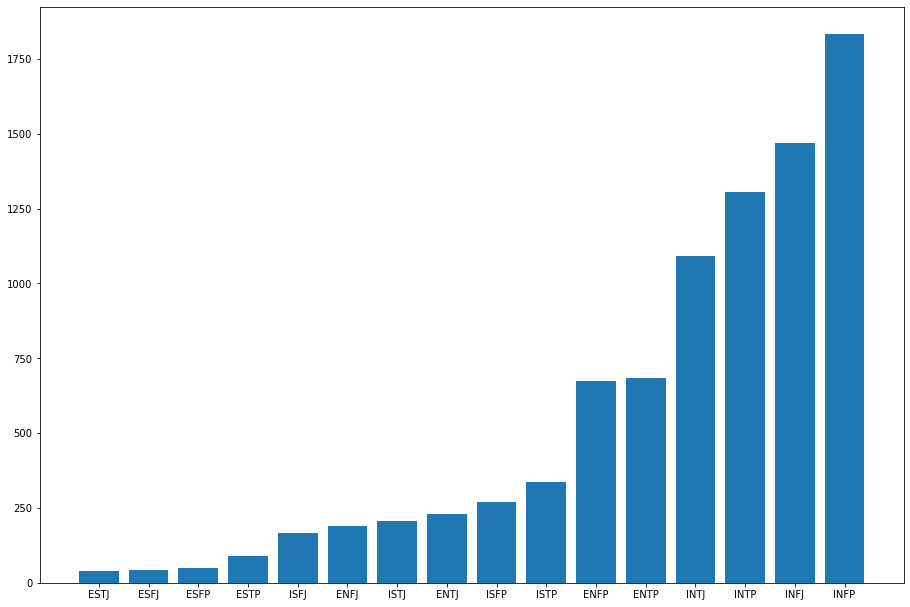

In [100]:
classes = count_class(df_data,True,True)

In [112]:
df_data.posts = df_data.posts.replace(r'[|||]', r' ', regex=True)
df_types = pd.DataFrame(df_data.drop('posts', 1))

In [84]:
df_types['is_E'] = df_data['type'].apply(lambda x: 1 if x[0] == 'E' else 0)
df_types['is_S'] = df_data['type'].apply(lambda x: 1 if x[1] == 'S' else 0)
df_types['is_T'] = df_data['type'].apply(lambda x: 1 if x[2] == 'T' else 0)
df_types['is_J'] = df_data['type'].apply(lambda x: 1 if x[3] == 'J' else 0)
df_types['posts'] = df_data['posts']
df_types.columns = ['type','is_E','is_S','is_T','is_J','posts']

df_types.head()

,type,is_E,is_S,is_T,is_J,posts
0,INFJ,0,0,0,1,'http://www.youtube.com/watch?v=qsXHcwe3krw ...
1,ENTP,1,0,1,0,'I'm finding the lack of me in these posts ver...
2,INTP,0,0,1,0,'Good one _____ https://www.youtube.com/wat...
3,INTJ,0,0,1,1,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,1,0,1,1,'You're fired. That's another silly misconce...


In [85]:
def up_down_sampling(data,count):
    types = list(set(data.type))
    defined = False
    for tp in types :
        print(tp)
        if not defined:
            defined = True
            tp_class_count = data.type.value_counts()[tp]
            if tp_class_count > count :
                df = data[data['type'] == tp].sample(count)
            else:
                df = data[data['type'] == tp].sample(count,replace = True)
        else:
            tp_class_count = data.type.value_counts()[tp]
            if tp_class_count > count :
                df = pd.concat([df, data[data['type'] == tp].sample(count)], axis=0)
            else:
                df = pd.concat([df, data[data['type'] == tp].sample(count,replace = True)], axis=0)
    return df

In [86]:
# Using Up_down Sampling for preparing trainable data   
df = up_down_sampling(df_types,600)

INTJ
ESFP
ISFJ
ENTJ
INFP
INFJ
ESTP
INTP
ISTJ
ENTP
ENFJ
ESFJ
ENFP
ISFP
ESTJ
ISTP


In [87]:
# Checking Trainable data 
count_class = df.type.value_counts()
count_class

INFJ    600
ISTP    600
ESFP    600
ENFJ    600
ENTP    600
ENTJ    600
ESTJ    600
ESTP    600
INFP    600
ISFP    600
ESFJ    600
ISTJ    600
INTP    600
ISFJ    600
INTJ    600
ENFP    600
Name: type, dtype: int64

In [88]:
# Function To check Classes in data 
def count_class(DataFrame,count = False ,plot = False):
    # considering 1st Column is for classes 
    Classes = list(df[df.columns[0]].unique())
    #print(Classes)
    if plot or count:
        count_type = df.groupby('type').count()
    if count : print(count_type)
    if plot:
        fig = plt.figure()
        ax = fig.add_axes([0,0,2,2])
        count_type_temp = count_type.sort_values('posts')
        ax.bar(count_type_temp.index,count_type_temp['posts'])
        plt.show()
    return Classes

      is_E  is_S  is_T  is_J  posts
type                               
ENFJ   600   600   600   600    600
ENFP   600   600   600   600    600
ENTJ   600   600   600   600    600
ENTP   600   600   600   600    600
ESFJ   600   600   600   600    600
ESFP   600   600   600   600    600
ESTJ   600   600   600   600    600
ESTP   600   600   600   600    600
INFJ   600   600   600   600    600
INFP   600   600   600   600    600
INTJ   600   600   600   600    600
INTP   600   600   600   600    600
ISFJ   600   600   600   600    600
ISFP   600   600   600   600    600
ISTJ   600   600   600   600    600
ISTP   600   600   600   600    600


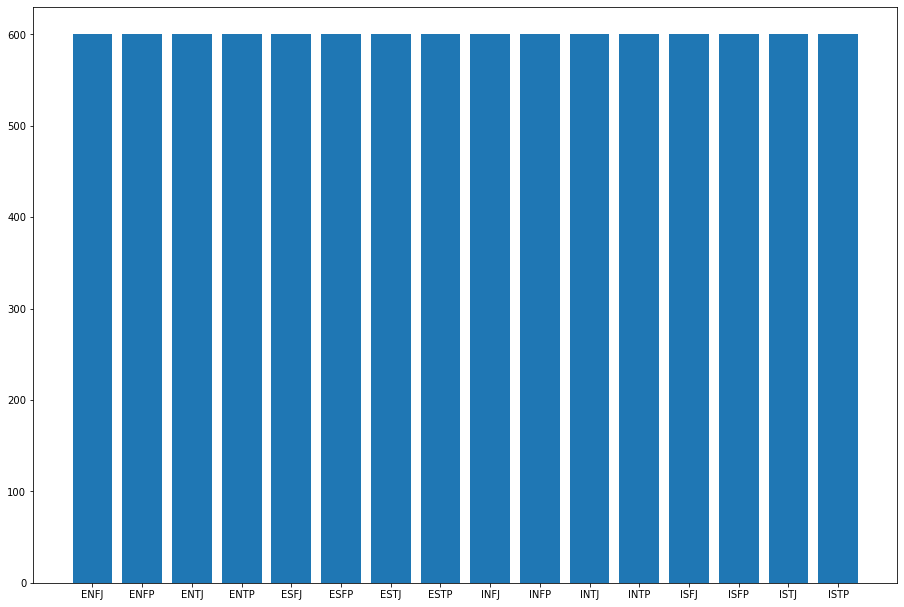

In [89]:
classes = count_class(df,True,True)

In [90]:
#Suffling DataFrame 
df = df.sample(frac = 1)
df

,type,is_E,is_S,is_T,is_J,posts
1584,INTP,0,0,1,0,'INTP not getting good grades? WHAT IS THIS. ...
2699,ENFJ,1,0,0,1,'https://www.youtube.com/watch?v=I6PYn-0XrgQ ...
4951,ESTP,1,1,1,0,'I cannot even begin to describe how screwed u...
4708,ENFP,1,0,0,0,'Hmmm... I don't really like the compatibility...
409,ENFP,1,0,0,0,'Can I just say I'm so glad and thankful that ...
...,...,...,...,...,...,...
5427,INFP,0,0,0,0,'I took myself to the movies today. Saw the mo...
3691,INFP,0,0,0,0,'https://www.youtube.com/watch?v=Qok9Ialei4c ...
8623,INFP,0,0,0,0,'So do you INFP peeps get jealous often? And b...
5538,ENFJ,1,0,0,1,'Tried the first strategy that is mentioned ab...


In [91]:
#Cleaning the data Round 1
def clean_text_round1(text):
    '''Make text lowercase, remove punctuation, remove words containing numbers, remove URL, remove @, '''
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('[^a-zA-Z\s]', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub("\s+", '', text)
    text = text.lstrip()
    text = text.rstrip()
    return text

round1 = lambda x: clean_text_round1(x)

data_posts_clean = pd.DataFrame(df_data.posts.apply(round1))
data_posts_clean


,posts
0,enfpandintjmomentssportscenternottoptenplayspr...
1,imfindingthelackofmeinthesepostsveryalarmingse...
2,goodoneofcoursetowhichisayiknowthatsmyblessing...
3,dearintpienjoyedourconversationtheotherdayesot...
4,yourefiredthatsanothersillymisconceptionthatap...
...,...
8670,ixfpjustbecauseialwaysthinkofcatsasfidomsforso...
8671,soifthisthreadalreadyexistssomeplaceelsewhichi...
8672,somanyquestionswhenidothesethingsiwouldtakethe...
8673,iamveryconflictedrightnowwhenitcomestowantingc...


In [92]:
# Tokenization - this is taken from SpaCy

re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
stemmer = LancasterStemmer()

def tokenize(s): 
    tokens = re_tok.sub(r' \1 ', s).split()
    return stemmer.stemWords(tokens)

In [93]:
#Remove stopword and also added the MBTI types to it
stop = set(stopwords.words('english'))
stop.update(['INFP','INFJ','INTP','INTJ','ENTP','ENFP','ISTP','ISFP','ENTJ','ISTJ','ENFJ','ISFJ','ESTP','ESFP','ESFJ','ESTJ'])

def remove_stopwords(row):
    return [t for t in row if t not in stop]

In [94]:

# load the FastText vectors in a dictionary:
from tqdm import tqdm

embeddings_index_FastText = {}
f = open('crawl-300d-2M.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
    except:
        continue
    embeddings_index_FastText[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index_FastText))

1999996it [01:56, 17111.88it/s]

Found 1999996 word vectors.


In [95]:
# Function to create a normalized vector for the whole sentence
def sent2vec(s, embeddings_index):
    words = str(s).lower()
    words = tokenize(words)
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [96]:
#Creating Train,Test and Validation Set
df.head()
X = df.type
y = df.posts

# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print (X_val.shape, y_val.shape)

(5760,) (5760,)
(1920,) (1920,)
(1920,) (1920,)
